### **Quantum Mechanics Basics (Postulates of QM, Schrödinger Equation, Measurement)**

Quantum mechanics is built on a small set of fundamental postulates that define the behavior of quantum systems. These postulates are the foundation of quantum computing because every gate, circuit, and algorithm is just an application of them. In short:

1. **State Postulate**: A quantum system is fully described by a state vector (ket) in a complex Hilbert space. For a qubit, this is |ψ⟩ = α|0⟩ + β|1⟩.  
2. **Evolution Postulate**: The time evolution of a quantum state is governed by the Schrödinger equation. In discrete terms, this means states evolve via unitary operators.  
3. **Measurement Postulate**: Measurements are described by a set of operators {Mᵢ}. The probability of outcome i is p(i) = ⟨ψ|Mᵢ†Mᵢ|ψ⟩, and the post-measurement state collapses accordingly.  
4. **Composite Systems Postulate**: The state space of a composite system is the tensor product of its subsystems. This allows entanglement.  

These rules look abstract, but they explain everything from superposition to entanglement to quantum circuits.


#### **Postulate 1: Quantum States**

A single qubit lives in a two-dimensional Hilbert space, spanned by basis states |0⟩ and |1⟩. A general state is a normalized linear combination |ψ⟩ = α|0⟩ + β|1⟩ where |α|² + |β|² = 1. This captures the probabilistic nature of quantum systems. For multiple qubits, the state space grows exponentially: n qubits → 2ⁿ basis states.

In [22]:
import numpy as np
from numpy import kron
import qiskit
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram,plot_distribution
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
from qiskit_aer import Aer, AerSimulator
import pylatexenc
import matplotlib.pyplot as plt

In [4]:
# Define basis states
zero = np.array([[1],[0]])
one  = np.array([[0],[1]])

# Define a general qubit state
alpha, beta = 1/np.sqrt(3), np.sqrt(2/3)
psi = alpha * zero + beta * one

print("State |ψ⟩ =\n", psi)
print("Norm check =", np.linalg.norm(psi))


State |ψ⟩ =
 [[0.57735027]
 [0.81649658]]
Norm check = 1.0


#### **Postulate 2: Schrödinger Equation and Unitary Evolution**

The continuous-time evolution of a closed quantum system is described by the Schrödinger equation:

$$ i \hbar \frac{d}{dt} |\psi(t)⟩ = H |\psi(t)⟩ $$

where H is the Hamiltonian of the system. Its solution is:

$$ |\psi(t)⟩ = e^{-iHt/\hbar} |\psi(0)⟩ $$

In quantum computing, this is discretized as unitary matrices (quantum gates). Every quantum gate corresponds to some Hamiltonian evolution over a specific time. For example, the Pauli-X gate corresponds to evolution under the Hamiltonian σₓ.


In [29]:
# Example: Time evolution under a simple Hamiltonian (Pauli-Z)
sigma_z = np.array([[1,0],[0,-1]])
H = sigma_z
t = np.pi/4
U = np.exp(-1j * H * t)  # exp(-iHt)

psi0 = (zero + one) / np.sqrt(2)   # |+⟩ state
psi_t = U @ psi0

print("Initial state |ψ(0)⟩ =\n", psi0)
print("\nEvolved state |ψ(t)⟩ =\n", psi_t)

Initial state |ψ(0)⟩ =
 [[0.70710678]
 [0.70710678]]

Evolved state |ψ(t)⟩ =
 [[1.20710678-0.5j]
 [1.20710678+0.5j]]


Now, let’s see the same idea in **Qiskit**. If we apply the Pauli-Z operator to the |+⟩ state, it adds a relative phase, which is equivalent to Schrödinger evolution under the σₓ Hamiltonian.


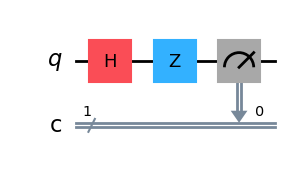

In [27]:
qreg = QuantumRegister(1, name = 'q')
creg = ClassicalRegister(1,name = 'c')
qc = QuantumCircuit(qreg,creg)
qc.h(0)      # prepare |+⟩
qc.z(0)      # evolve under Z
qc.measure(0,0)
qc.draw("mpl")

Raw Counts: {'0': 10035, '1': 9965}


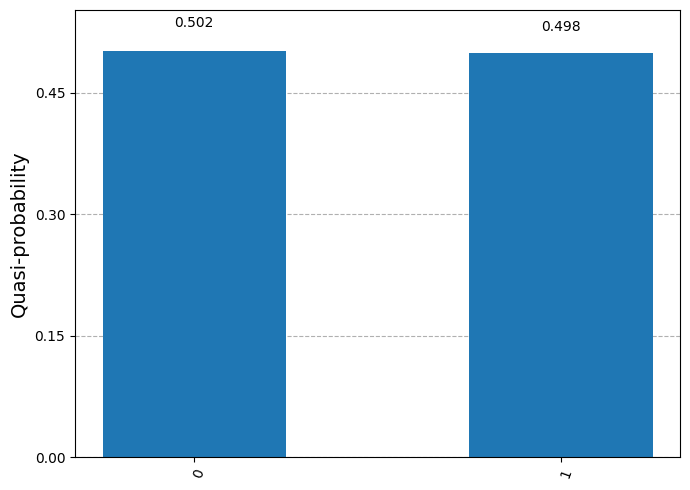

In [28]:
# Step 1: Simulate using Sampler and AerSimulator
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_transpiled = pass_manager.run(qc)

sampler = Sampler(mode=backend)
job_result = sampler.run([qc_transpiled], shots=20000).result()

# Extract measurement counts from result
counts = job_result[0].data.c.get_counts()
# Note: The exact access pattern may vary with Qiskit version;
# sometimes it's .data.c or .data.meas — adjust accordingly based on your transpiled circuit.

print("Raw Counts:", counts)
plot_distribution(counts)


#### **Postulate 3: Measurement**

Measurement is the bridge between the quantum and classical worlds. Measuring |ψ⟩ = α|0⟩ + β|1⟩ in the computational basis yields 0 with probability |α|² and 1 with probability |β|². After measurement, the state collapses to the outcome observed. This probabilistic collapse is unique to quantum mechanics.

In [12]:
# Simulate probabilities directly
alpha, beta = 0.6, 0.8j
psi = np.array([[alpha],[beta]])
psi = psi / np.linalg.norm(psi)

p0 = np.abs(zero.T.conj() @ psi)**2
p1 = np.abs(one.T.conj() @ psi)**2

print("Prob(0) =", p0)
print("Prob(1) =", p1)

Prob(0) = [[0.36]]
Prob(1) = [[0.64]]


#### **Measurement in Qiskit**
Let’s prepare a state √(3/4)|0⟩ + √(1/4)|1⟩ and measure it 1000 times to verify the probability distribution matches theory.


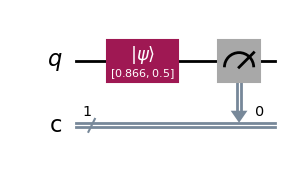

In [20]:
qreg = QuantumRegister(1, name="q")
creg = ClassicalRegister(1, name="c")
qc = QuantumCircuit(qreg,creg)
qc.initialize([np.sqrt(3/4), np.sqrt(1/4)], 0)
qc.measure(0,0)
qc.draw("mpl")

Raw Counts: {'0': 14992, '1': 5008}


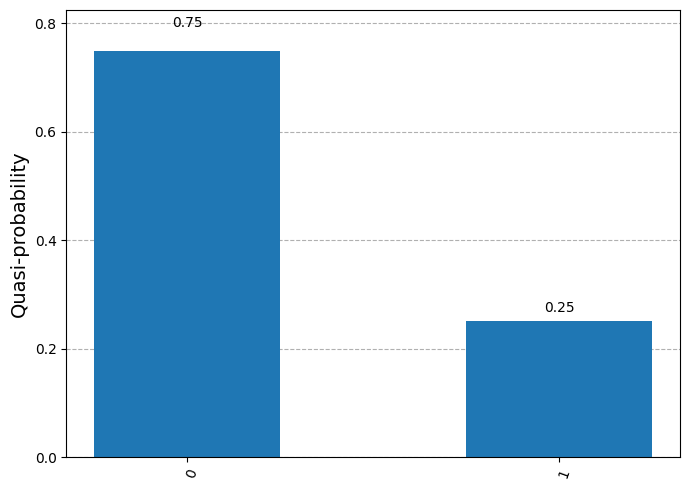

In [24]:
# Step 1: Simulate using Sampler and AerSimulator
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_transpiled = pass_manager.run(qc)

sampler = Sampler(mode=backend)
job_result = sampler.run([qc_transpiled], shots=20000).result()

# Extract measurement counts from result
counts = job_result[0].data.c.get_counts()
# Note: The exact access pattern may vary with Qiskit version;
# sometimes it's .data.c or .data.meas — adjust accordingly based on your transpiled circuit.

print("Raw Counts:", counts)
plot_distribution(counts)

#### **Postulate 4: Composite Systems**

If one system is in state |ψ⟩ and another in |ϕ⟩, the combined system is |ψ⟩⊗|ϕ⟩. This tensor product structure leads to entanglement, where the state cannot be factored into individual subsystems. For example, the Bell state |Φ+⟩ = (|00⟩ + |11⟩)/√2 cannot be written as |ψ⟩⊗|ϕ⟩.


In [15]:
# Construct Bell state manually
bell = (kron(zero, zero) + kron(one, one)) / np.sqrt(2)
print("|Φ+⟩ =\n", bell)

|Φ+⟩ =
 [[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]


#### **Bell State in Qiskit**
We can also create this state using quantum gates.


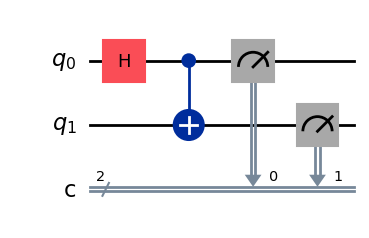

In [34]:
qreg = QuantumRegister(2, name = 'q')
creg = ClassicalRegister(2, name = 'c')
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1],[0,1])
qc.draw("mpl")


Raw Counts: {'00': 10206, '11': 9794}


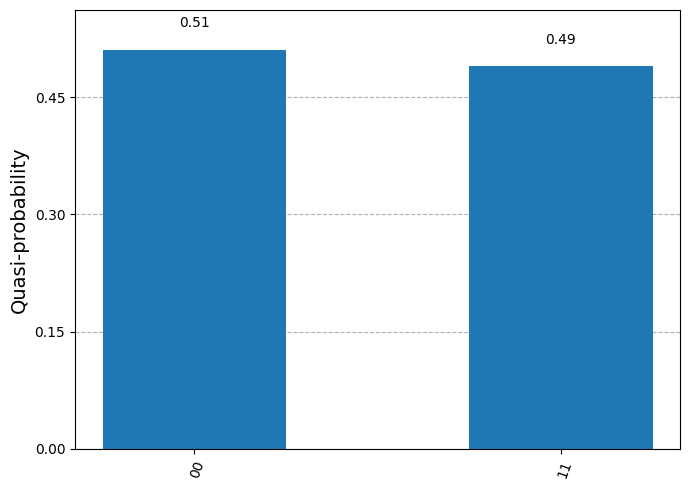

In [35]:
# Step 1: Simulate using Sampler and AerSimulator
backend = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=3)
qc_transpiled = pass_manager.run(qc)

sampler = Sampler(mode=backend)
job_result = sampler.run([qc_transpiled], shots=20000).result()

# Extract measurement counts from result
counts = job_result[0].data.c.get_counts()
# Note: The exact access pattern may vary with Qiskit version;
# sometimes it's .data.c or .data.meas — adjust accordingly based on your transpiled circuit.

print("Raw Counts:", counts)
plot_distribution(counts)


### **Key Takeaways**

- **Quantum states** are vectors in complex Hilbert spaces.  
- **Time evolution** follows the Schrödinger equation, discretized as unitary gates in quantum computing.  
- **Measurements** yield probabilistic outcomes and collapse the state, linking quantum to classical.  
- **Composite systems** use tensor products, enabling entanglement, a uniquely quantum resource.  
- These postulates are not just theory: they map directly to circuits, gates, and measurement outcomes in Qiskit.  